# XOR

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

In [5]:
# get train data
def get_data(filename):
    elements = np.zeros((4, 3),dtype=float)  #先建立一個 4x3的全零方陣A，並且資料的型別設定為float浮點型
    f = open(filename)        #開啟資料檔案檔案
    lines = f.readlines()      #把全部資料檔案讀到一個列表lines中
    row = 0            #矩陣的行，從0行開始
    lineNum = 0
    for line in lines:       #把lines中的資料逐行讀取出來
        if(lineNum==0):    
            lineNum += 1
            continue
        list = line.strip('\n').split('\t') #處理逐行資料：strip表示把頭尾的'\n'去掉，split表示以\t分割行資料，然後把處理後的行資料返回到list列表中
        elements[row:] = list[0:3]        #把處理後的資料放到方陣A中。list[0:3]表示列表的0~2列資料放到矩陣中的row行
        row += 1
    f.close()
    return elements #回傳矩陣資料

# activation function
def sigmoid(x):
    return  1 / (1 + np.exp(-x))

# output activation function
def softmax(x):
    x = x - np.max(x)
    return np.exp(x) / np.sum(np.exp(x))

# 所有訓練資料的y、所有訓練資料的t
def cross_entropy_error(y, t):
    return -np.sum(t * np.log(y + 1e-7))  #log(0)為負無限大，所以要加上微小值 1e-7

def numerical_gradient(f, x):     
    h = 1e-4 # 0.0001
    grad = np.zeros_like(x)
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite']) 
    #numpy的迭代器，multi_index：多重索引[輸出：就是陣列索引號（0,0）（0,1）等]; readwrite：對x有可讀可寫的許可權
    while not it.finished:
        idx = it.multi_index
        
        #偏微分
        tmp_val = x[idx]
        x[idx] = float(tmp_val) + h
        fxh1 = f(x) # f(x+h)
        
        x[idx] = tmp_val - h 
        fxh2 = f(x) # f(x-h)
        grad[idx] = (fxh1 - fxh2) / (2*h)
        
        x[idx] = tmp_val 
        it.iternext()        
    return grad

# 兩層感知器-XOR

In [11]:
class TwoLayerPerceptron:
    def __init__(self, learnRate):    
        self.w1 = np.random.randn(2 + 1, 2)
        self.w2 = np.random.randn(2 + 1, 1)
#         self.w1 = np.array([[0.90, -0.41], [0.07, 1.39], [1.49, -0.95]])
#         self.w2 = np.array([[0.27], [-0.74], [-1.64]])
        print('w1', self.w1, '\nw2', self.w2)
        
        self.lr = learnRate
        
    def predict(self, x):    
        W1, W2 = self.w1, self.w2

        a1 = np.dot(x, W1)  
        z1 = np.hstack([sigmoid(a1), 1])
        a2 = np.dot(z1, W2)
        self.y = sigmoid(a2)  #softmax sigmoid
    
        return self.y
        
    # x:input data x, t:train weight
    def loss(self, x, t):
        y = self.predict(x)
#         return abs(y-t) 
        return np.sum((y-t)**2) #mse
#         return cross_entropy_error(y, t)

    # x:input data x, t:train weight
    def gradient(self, x, t):
        loss_W = lambda w: self.loss(x, t)
        
        grads = {}
        grads['w1'] = numerical_gradient(loss_W, self.w1)  
        grads['w2'] = numerical_gradient(loss_W, self.w2)
        
        return grads  
        
    def mse(self, t):
        return (t-self.y)**2
    
    def test(self, x, t):
        print("XOR test-> ")
        for i in range(len(x)):
            X = np.array(x[i])
            Y = self.predict(X)
            print('\t', X, '--> t:', t[i], '\ty:', Y)
    
    def drawFig(self, title, x1, x2):
        plt.grid(True, linestyle='-')
        
        plt.title(title + " Gate")
        plt.xlabel("x1")
        plt.ylabel("x2")
        
        w = self.w1
        X = np.arange(-1,2,0.1)
        
        # 第一層感知器
        Y1 = (-w[2][0]-w[0][0]*X)/w[1][0]
        plt.plot(X,Y1, color='blue') 
        lineName = r'Perceptron1:\n{0:.3f}*x1 + {1:.3f}*x2 + {2:.3f} = 0'.format(w[0][0], w[1][0], w[2][0])
        plt.annotate(lineName, xy=(0.3, (-w[2][0]-w[0][0]*0.3)/w[1][0]), xytext=(0.7, (-w[2][0]-w[0][0]*0.5)/w[1][0]-0.6),
            arrowprops=dict(facecolor='lightblue', shrink=0.05))
        
        # 第二層感知器
        Y2 = (-w[2][1]-w[0][1]*X)/w[1][1]
        plt.plot(X,Y2, color='red') 
        lineName = r'Perceptron2:\n{0:.3f}*x1 + {1:.3f}*x2 + {2:.3f} = 0'.format(w[0][1], w[1][1], w[2][1])  
        plt.annotate(lineName, xy=(0.3, (-w[2][1]-w[0][1]*0.3)/w[1][1]), xytext=(0.7, (-w[2][1]-w[0][1]*0.5)/w[1][1]-0.6),
            arrowprops=dict(facecolor='lightpink', shrink=0.05))

        
        plt.fill_between(X, Y1, Y2, color='gray', alpha='0.8')
        
        # 測試資料
        plt.scatter(np.array([0,1]), np.array([0,1]), color='y', marker='o', label='target=0')
        plt.scatter(np.array([0,1]), np.array([1,0]), color='g', marker='*', label='target=1')
        plt.legend(loc = 'upper right')
        for xy in zip(x1, x2):
            plt.annotate("P(%d,%d)" % xy, xy=xy, xytext=(-20, 10), textcoords='offset points')
        
        plt.savefig('xor.png')
        plt.show()    
        
    def drawFig2(self, title, lossArr):
        plt.title(title)
        x = np.arange(0, len(lossArr), 1)
        plt.plot(x, lossArr[x], label='loss')
        plt.xlabel("epochs")
        plt.ylabel("loss")
        plt.ylim(0, 1.0)
        plt.legend(loc='upper right')
        plt.savefig('train_loss.png')
        plt.show()

input learnRate: 0.9
epoch: 1000
w1 [[ 0.60527966  0.2735667 ]
 [-0.49966154  0.25162634]
 [ 2.6400765  -1.1944357 ]] 
w2 [[-0.58812376]
 [-0.18139685]
 [-0.96195197]]
Epoch: 0 	 loss: [0.35110565]
Epoch: 1 	 loss: [0.30739347]
Epoch: 2 	 loss: [0.29422285]
Epoch: 3 	 loss: [0.29827348]
Epoch: 4 	 loss: [0.30306204]
Epoch: 5 	 loss: [0.305974]
Epoch: 6 	 loss: [0.30752396]
Epoch: 7 	 loss: [0.30830117]
Epoch: 8 	 loss: [0.30866678]
Epoch: 9 	 loss: [0.30881799]
Epoch: 10 	 loss: [0.30885862]
Epoch: 11 	 loss: [0.30884253]
Epoch: 12 	 loss: [0.30879744]
Epoch: 13 	 loss: [0.30873761]
Epoch: 14 	 loss: [0.3086703]
Epoch: 15 	 loss: [0.3085992]
Epoch: 16 	 loss: [0.30852619]
Epoch: 17 	 loss: [0.30845218]
Epoch: 18 	 loss: [0.30837759]
Epoch: 19 	 loss: [0.30830262]
Epoch: 20 	 loss: [0.30822733]
Epoch: 21 	 loss: [0.30815171]
Epoch: 22 	 loss: [0.30807572]
Epoch: 23 	 loss: [0.3079993]
Epoch: 24 	 loss: [0.30792239]
Epoch: 25 	 loss: [0.30784493]
Epoch: 26 	 loss: [0.30776684]
Epoch: 27 

Epoch: 263 	 loss: [0.28978701]
Epoch: 264 	 loss: [0.28966636]
Epoch: 265 	 loss: [0.2895395]
Epoch: 266 	 loss: [0.28940619]
Epoch: 267 	 loss: [0.28926618]
Epoch: 268 	 loss: [0.28911922]
Epoch: 269 	 loss: [0.28896505]
Epoch: 270 	 loss: [0.28880341]
Epoch: 271 	 loss: [0.28863404]
Epoch: 272 	 loss: [0.28845665]
Epoch: 273 	 loss: [0.28827098]
Epoch: 274 	 loss: [0.28807673]
Epoch: 275 	 loss: [0.28787364]
Epoch: 276 	 loss: [0.2876614]
Epoch: 277 	 loss: [0.28743973]
Epoch: 278 	 loss: [0.28720834]
Epoch: 279 	 loss: [0.28696692]
Epoch: 280 	 loss: [0.28671519]
Epoch: 281 	 loss: [0.28645284]
Epoch: 282 	 loss: [0.28617959]
Epoch: 283 	 loss: [0.28589512]
Epoch: 284 	 loss: [0.28559916]
Epoch: 285 	 loss: [0.2852914]
Epoch: 286 	 loss: [0.28497156]
Epoch: 287 	 loss: [0.28463935]
Epoch: 288 	 loss: [0.2842945]
Epoch: 289 	 loss: [0.28393673]
Epoch: 290 	 loss: [0.28356579]
Epoch: 291 	 loss: [0.2831814]
Epoch: 292 	 loss: [0.28278334]
Epoch: 293 	 loss: [0.28237136]
Epoch: 294 	 

Epoch: 523 	 loss: [0.00912514]
Epoch: 524 	 loss: [0.00903855]
Epoch: 525 	 loss: [0.00895349]
Epoch: 526 	 loss: [0.00886993]
Epoch: 527 	 loss: [0.00878783]
Epoch: 528 	 loss: [0.00870714]
Epoch: 529 	 loss: [0.00862784]
Epoch: 530 	 loss: [0.00854989]
Epoch: 531 	 loss: [0.00847326]
Epoch: 532 	 loss: [0.0083979]
Epoch: 533 	 loss: [0.0083238]
Epoch: 534 	 loss: [0.00825093]
Epoch: 535 	 loss: [0.00817924]
Epoch: 536 	 loss: [0.00810872]
Epoch: 537 	 loss: [0.00803934]
Epoch: 538 	 loss: [0.00797107]
Epoch: 539 	 loss: [0.00790388]
Epoch: 540 	 loss: [0.00783775]
Epoch: 541 	 loss: [0.00777266]
Epoch: 542 	 loss: [0.00770858]
Epoch: 543 	 loss: [0.00764548]
Epoch: 544 	 loss: [0.00758336]
Epoch: 545 	 loss: [0.00752217]
Epoch: 546 	 loss: [0.00746192]
Epoch: 547 	 loss: [0.00740256]
Epoch: 548 	 loss: [0.00734409]
Epoch: 549 	 loss: [0.00728649]
Epoch: 550 	 loss: [0.00722973]
Epoch: 551 	 loss: [0.0071738]
Epoch: 552 	 loss: [0.00711867]
Epoch: 553 	 loss: [0.00706435]
Epoch: 554 

Epoch: 791 	 loss: [0.00240096]
Epoch: 792 	 loss: [0.00239402]
Epoch: 793 	 loss: [0.00238712]
Epoch: 794 	 loss: [0.00238026]
Epoch: 795 	 loss: [0.00237344]
Epoch: 796 	 loss: [0.00236665]
Epoch: 797 	 loss: [0.0023599]
Epoch: 798 	 loss: [0.00235319]
Epoch: 799 	 loss: [0.00234652]
Epoch: 800 	 loss: [0.00233988]
Epoch: 801 	 loss: [0.00233327]
Epoch: 802 	 loss: [0.0023267]
Epoch: 803 	 loss: [0.00232017]
Epoch: 804 	 loss: [0.00231367]
Epoch: 805 	 loss: [0.00230721]
Epoch: 806 	 loss: [0.00230078]
Epoch: 807 	 loss: [0.00229439]
Epoch: 808 	 loss: [0.00228803]
Epoch: 809 	 loss: [0.0022817]
Epoch: 810 	 loss: [0.0022754]
Epoch: 811 	 loss: [0.00226914]
Epoch: 812 	 loss: [0.00226292]
Epoch: 813 	 loss: [0.00225672]
Epoch: 814 	 loss: [0.00225056]
Epoch: 815 	 loss: [0.00224443]
Epoch: 816 	 loss: [0.00223833]
Epoch: 817 	 loss: [0.00223226]
Epoch: 818 	 loss: [0.00222623]
Epoch: 819 	 loss: [0.00222022]
Epoch: 820 	 loss: [0.00221425]
Epoch: 821 	 loss: [0.0022083]
Epoch: 822 	 

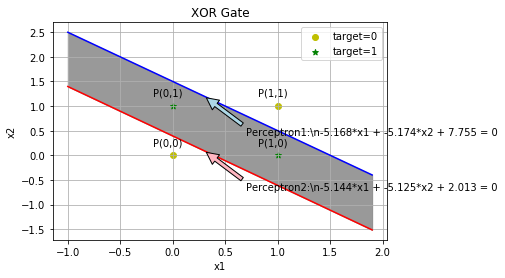

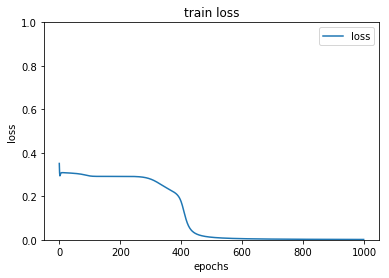

In [12]:
if __name__ == "__main__":
    filename = 'trainData/XOR_in.txt'
    data = get_data(filename)
    x = np.delete(data, -1, axis=1) # 刪除最後一列後得到x1、x2
    x = np.hstack([x,np.ones((4,1), dtype='int16')])  # 放入b，建立4*1全1陣列
    t = np.hsplit(data, 3)[2].ravel() # 取得最後一列，並轉成一維陣列
    lr = float(input('input learnRate: '))
    epoch = int(input('epoch: ')) 
    network = TwoLayerPerceptron(lr)
            
    ''' train '''
    train_loss_list = []
    for j in range(epoch):        
        lossMse = 0
        for index,X in enumerate(x):
            grad = network.gradient(X, t[index])
            network.w1 -= lr * grad['w1'] #  network.b1 = network.b1 - lr * grad['b1'] 
            network.w2 -= lr * grad['w2'] #  network.b2 = network.b2 - lr * grad['b2'] 
            
            lossMse += network.mse(t[index])
            
        lossMse = lossMse / len(x)
        print('Epoch:', j, '\t loss:', lossMse)
        
        train_loss_list.append(lossMse[0])
        
        if(lossMse<=0.001):
            break
        
    print('  final_w1: ', network.w1, '\n  final_w2: ', network.w2)
    network.test(x, t)
    network.drawFig("XOR", np.hsplit(x, 3)[0].ravel() , np.hsplit(data, 3)[1].ravel()) 
    network.drawFig2("train loss", np.array(train_loss_list))